<a href="https://colab.research.google.com/github/sagerpascal/first-order-model/blob/master/presentation/presentation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only with Colab:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# !conda update -n base conda -y
# !conda create -n bs_ds -y
# !conda init zsh
# !conda activate bs_ds

In [3]:
!python --version
!pip install https://download.pytorch.org/whl/cu100/torch-1.0.0-cp37-cp37m-linux_x86_64.whl
!pip install torchvision==0.2.2
# !pip install pytorch==1.0.0 torchvision==0.2.1 cuda100

Python 3.7.6


In [4]:
# %cd /content/gdrive/My Drive/first-order-model
%cd /home/jovyan/work
!ls

/home/jovyan/work
animate.py	 data		      LICENSE.md	 result.mp4
augmentation.py  demo.ipynb	      logger.py		 result_.mp4
checkpoints	 demo.py	      modules		 run.py
config		 Dockerfile	      presentation	 sup-mat
copy_sound.py	 face-alignment       __pycache__	 sync_batchnorm
crop.mp4	 finished_video.mp4   README.md		 train.py
crop_.mp4	 finished_video_.mp4  reconstruction.py
crop-video.py	 frames_dataset.py    requirements.txt


In [5]:
!pip install -r requirements.txt

Processing /home/jovyan/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9/PyYAML-5.1-cp37-cp37m-linux_x86_64.whl
  Using cached scikit_image-0.14.0-cp37-cp37m-manylinux1_x86_64.whl (25.3 MB)
  Using cached scikit_learn-0.19.2-cp37-cp37m-manylinux1_x86_64.whl (4.9 MB)
  Using cached scipy-1.1.0-cp37-cp37m-manylinux1_x86_64.whl (31.2 MB)
Processing /home/jovyan/.cache/pip/wheels/58/85/f9/3a8ac8d6acedfb76fb78ed9dedd7b5c86dc5bfdef4b2427219/toolz-0.9.0-py3-none-any.whl
  Using cached torchvision-0.2.1-py2.py3-none-any.whl (54 kB)
  Using cached tqdm-4.24.0-py2.py3-none-any.whl (43 kB)
ERROR: distributed 2.18.0 has requirement cloudpickle>=1.3.0, but you'll have cloudpickle 0.5.3 which is incompatible.
ERROR: distributed 2.18.0 has requirement dask>=2.9.0, but you'll have dask 0.18.2 which is incompatible.
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.3.1
ERROR: Cannot uninstall 'PyYAML'. It is a distutils installed project and thus we c

In [6]:
# %cd /content/gdrive/My Drive/first-order-model/face-alignment
%cd face-alignment
!ls

/home/jovyan/work/face-alignment
build  Dockerfile  face_alignment	    README.md	      setup.py
conda  docs	   face_alignment.egg-info  requirements.txt  test
dist   examples    LICENSE		    setup.cfg	      tox.ini


In [7]:
!pip install -r requirements.txt


In [8]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing face_alignment.egg-info/PKG-INFO
writing dependency_links to face_alignment.egg-info/dependency_links.txt
writing requirements to face_alignment.egg-info/requires.txt
writing top-level names to face_alignment.egg-info/top_level.txt
reading manifest file 'face_alignment.egg-info/SOURCES.txt'
writing manifest file 'face_alignment.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/face_alignment
copying build/lib/face_alignment/api.py -> build/bdist.linux-x86_64/egg/face_alignment
creating build/bdist.linux-x86_64/egg/face_alignment/detection
creating build/bdist.linux-x86_64/egg/face_alignment/detection/folder
copying build/lib/face_alignment/detection/folder/folder_detector.py -> build/bdist.linux-x86_64/egg/face_alignment/detection/folder
copying build/lib/face_alignment/detection/folder/__

In [9]:
# %cd /content/gdrive/My Drive/first-order-model
%cd ..
!ls

/home/jovyan/work
animate.py	 data		      LICENSE.md	 result.mp4
augmentation.py  demo.ipynb	      logger.py		 result_.mp4
checkpoints	 demo.py	      modules		 run.py
config		 Dockerfile	      presentation	 sup-mat
copy_sound.py	 face-alignment       __pycache__	 sync_batchnorm
crop.mp4	 finished_video.mp4   README.md		 train.py
crop_.mp4	 finished_video_.mp4  reconstruction.py
crop-video.py	 frames_dataset.py    requirements.txt


In [10]:
import os

files_to_remove = ['crop.mp4', 'result.mp4', 'finished_video.mp4', 'presentation/crop.mp4', 'presentation/result.mp4', 'presentation/finished_video.mp4']

for f in files_to_remove:
  try:
    os.remove(f)
  except Exception as e:
    print(e)


[Errno 2] No such file or directory: 'presentation/crop.mp4'
[Errno 2] No such file or directory: 'presentation/result.mp4'
[Errno 2] No such file or directory: 'presentation/finished_video.mp4'


In [11]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import matplotlib.pyplot as plt
import skimage
import imageio
import math
import face_alignment
import numpy as np
import matplotlib.patches as mpatches
from IPython.display import HTML
from base64 import b64encode

import os
import yaml
from tqdm import tqdm

from skimage.transform import resize
from skimage import img_as_ubyte
import torch
from sync_batchnorm import DataParallelWithCallback

from modules.generator import OcclusionAwareGenerator
from modules.keypoint_detector import KPDetector
from animate import normalize_kp
from scipy.spatial import ConvexHull


%matplotlib inline


In [14]:
def plot_images(images, bboxes=None, titles=None):
    fig = plt.figure(figsize=(15, 15))
    n_row = 4
    n_col = math.ceil(len(images) / n_row)
    for i, im in enumerate(images):
        ax = plt.subplot(n_col, n_row, i+1)
        ax.imshow(im)
        if titles is not None:
            ax.set_title(titles[i])
        if bboxes is not None:
            (x1, y1, x2, y2) = bboxes[i].flatten()
            rect = mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
    plt.show()

# Quellen

- Siarohin, A & Lathuilière, S & Tulyakov, S & Ricci, E & Sebe, N 2019 'First Order Motion Model for Image Animation', _Conference on Neural Information Processing Systems (NeurIPS)_, Dezember, 2019

- Bulat, A & Tzimiropoulos, G 2017 'How far are we from solving the 2D & 3D Face Alignment problem? (and a dataset of 230,000 3D facial landmarks', _International Conference on Computer Vision_, 2017

# Ziel

In dieser Präsentation wird ein Deep-Fake erzeugt. Dazu wird das Bild von Guy Parmelin entsprechend dem zuvor gezeigten Video animiert.


<img src="https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/parmelin.jpg?raw=1" alt="Guy Parmelin" style="width:200px;height:200px;">

Damit das Bild animiert werden kann, müssen die Bewegungen aus dem Video extrahiert und auf das Bild übertragen werden. Dadurch entsteht ein gefälschtes Video,
in welchem Guy Parmelin den Inhalt aus dem Video "nachspricht".


# Data Preprocessing
Zuerst werden die Daten vorbereitet. Zum einen muss dazu das Bild von Guy Parmelin geladen werden, zum anderen müssen wir das Video editieren. Da nur das Gesicht animiert werden soll, wird das Video entsprechend zugeschnitten und verkleinert. Dadurch müssen weniger Daten berechnet werden und der Algorithmus kann das Bild deutlich effizienter verarbeiten.

### Video

Ein Video besteht aus mehreren Frames:

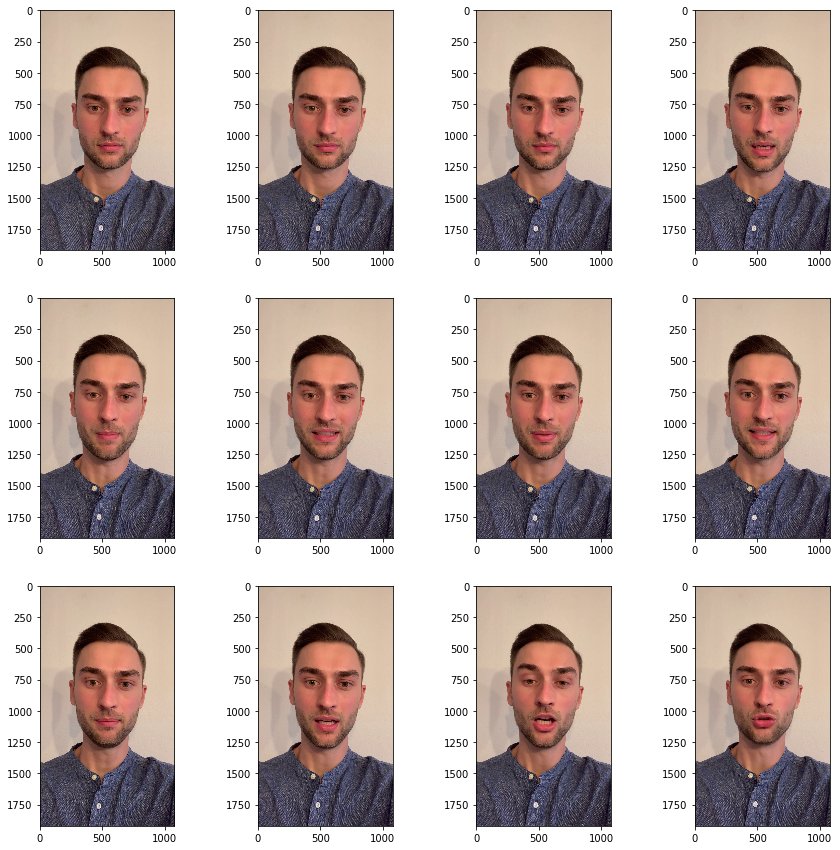

In [15]:
path_video = "presentation/data/driver.mp4"
video = imageio.get_reader(path_video)

frames = [f for f in video]
first_frames = [frames[i] for i in range(0,84,7)]
plot_images(first_frames)

### Bounding Boxes

Für das Fake-Video werden nur die Bewegungen des Gesichts benötigt. Daher wird das Video entsprechend zugeschnitten.
In einem ersten Schritt wird in den einzelnen Frames nach dem Gesicht und gesucht:

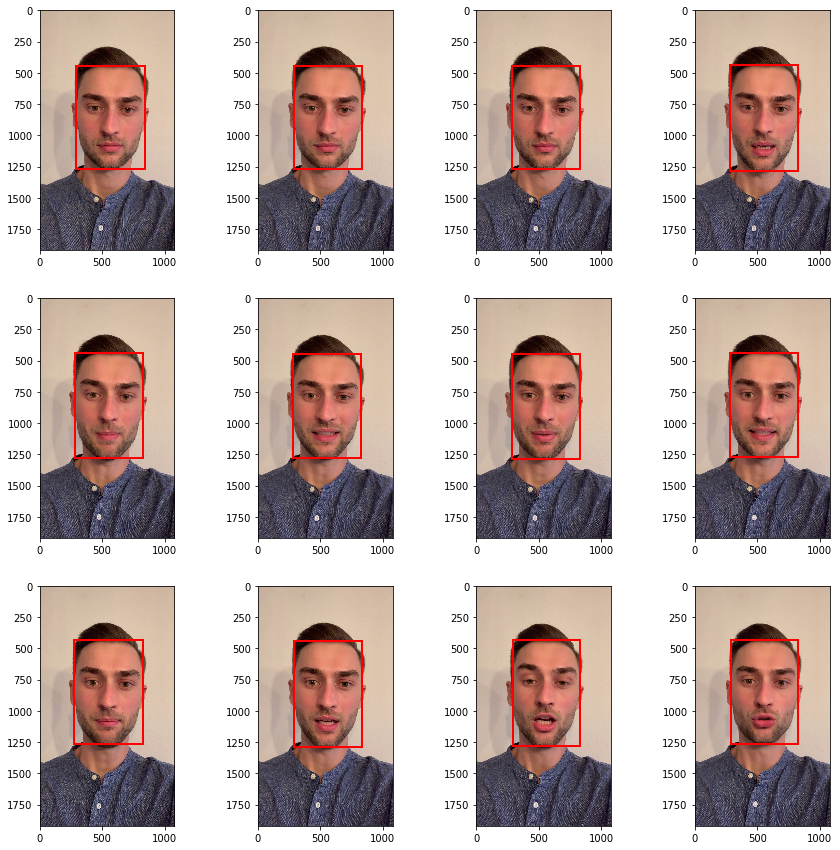

In [16]:
device = 'cuda'
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, device=device)

def extract_bbox(frame, fa):
    if max(frame.shape[0], frame.shape[1]) > 640:
        scale_factor =  max(frame.shape[0], frame.shape[1]) / 640.0
        frame = resize(frame, (int(frame.shape[0] / scale_factor), int(frame.shape[1] / scale_factor)))
        frame = img_as_ubyte(frame)
    else:
        scale_factor = 1
    frame = frame[..., :3]
    bboxes = fa.face_detector.detect_from_image(frame[..., ::-1])
    if len(bboxes) == 0:
        return []
    return np.array(bboxes)[:, :-1] * scale_factor

bboxes = []
for frame in first_frames:
    bboxes.append(extract_bbox(frame, fa))
plot_images(first_frames, bboxes)

Jedes Frame hat die Bounding Box (das rote Rechteck) an einer anderen Position. Deshalb wird ein Bildausschnitt definiert, der grösser ist als sämtliche Bounding Boxes und diese umschliesst. Zusätzlich wird eine Toleranz hinzu addiert, bevor das Video zugeschnitten wird.

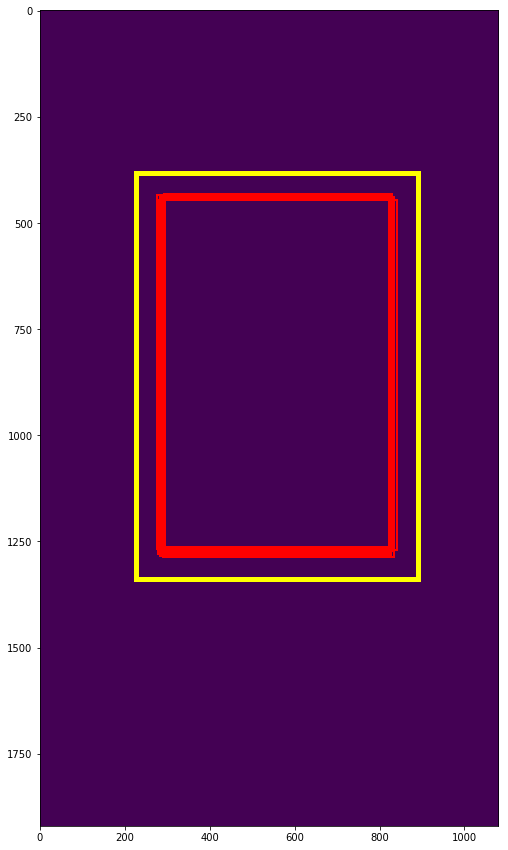

In [17]:
x, y = [], []
tol = 50
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(np.ones((1920, 1080)))
for bbox in bboxes:
    (x1, y1, x2, y2) = bbox.flatten()
    ax.add_patch(mpatches.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
    x.append(x1), x.append(x2), y.append(y1), y.append(y2)
ax.add_patch(mpatches.Rectangle((np.min(x)-tol, np.min(y)-tol), np.max(x)-np.min(x)+2*tol, np.max(y)-np.min(y)+2*tol, fill=False, edgecolor='yellow', linewidth=5))
plt.show()

In [18]:
driv_video = "crop.mp4"
img = "presentation/data/parmelin.jpg"

### Video zuschneiden

Nachdem der gewünschte Bildausschnitt definiert wurde, kann das Video entsprechend zugeschnitten werden. Zusätzlich wird die Grösse von jedem Frame verkleinert, um die Laufzeit des Algorithmus zu reduzieren:

In [19]:
!python crop-video.py --inp presentation/data/driver.mp4

189it [00:44,  4.29it/s]
ffmpeg -i presentation/data/driver.mp4 -ss 0.0 -t 6.2729396062729395 -filter:v "crop=1072:1073:0:316, scale=256:256" crop.mp4
ffmpeg version 4.2.2-1ubuntu1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-3ubuntu1)
  configuration: --prefix=/usr --extra-version=1ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-lib

In [20]:
mp4 = open(driv_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Bild laden

Neben dem Video wird auch das Bild von Guy Parmelin benötigt:

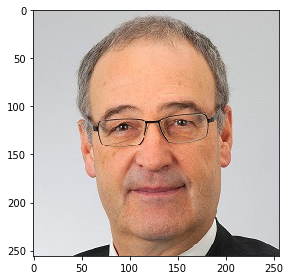

In [21]:
skimage.io.imshow(img)

# Deep Fake

Nachdem die Daten vorbereitet sind, kann das Deep-Fake Video erzeugt werden. Dies funktioniert mit zwei Modulen


1. Modul zur Bewegungsabschätzung
2. Modul zur Bilderzeugung


### Modul zur Bewegungsabschätzung
- Ein neuronales Netzwerk lernt in Bildern Schlüsselpunkte zu erkennen. Wenn die Schlüsselpunkte aus einzelnen Videoframes verglichen werden, können die Bewegungen abgeschätzt werden

![Keypoints](https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/keypoints.png?raw=1)

- Die Bewegungen werden dann kodiert an das Modul zur Bilderzeugung übergeben


### Modul zur Bilderzeugung

- Das zweite Modul erzeugt das Bild. Dazu schätzt es ab, welche Bewegungen durch Verzerren des Bildes bewirkt werden können und wo das Bild "übermalt" werden soll

<img src="https://github.com/sagerpascal/first-order-model/blob/master/presentation/data/keypoints_gen.png?raw=1" alt="Keypoints" width="300"/>


- Anschliessend werden die angepassten Bilder zu einem Video zusammengefügt

<br>
<br>
<br>


### Training

Ein neuronales Netzwerk erlernt wie es diese Aufgaben vollautomatisch erfüllen kann. Dieses Erlernen erfordert jedoch viel Rechenleistung und dauert lange.

Deshalb verwendet wir dieses Beispiel ein bereits trainiertes Netzwerk:

In [22]:
def load_checkpoints(config_path, checkpoint_path, cpu=True):

    with open(config_path) as f:
        config = yaml.load(f)

    generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
    if not cpu:
        generator.cuda()

    kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                             **config['model_params']['common_params'])
    if not cpu:
        kp_detector.cuda()
    
    if cpu:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(checkpoint_path)
 
    generator.load_state_dict(checkpoint['generator'])
    kp_detector.load_state_dict(checkpoint['kp_detector'])
    
    if not cpu:
        generator = DataParallelWithCallback(generator)
        kp_detector = DataParallelWithCallback(kp_detector)

    generator.eval()
    kp_detector.eval()
    
    return generator, kp_detector

Das neuronale Netzwerk sucht zuerst die Schlüsselpunkte im Bild und danach im Video. Anhand dieser Daten wird dann das neue Video erzeugt: 

In [23]:
def make_animation(source_image, driving_video, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=True):
    with torch.no_grad():
        predictions = []
        source = torch.tensor(source_image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
        if not cpu:
            source = source.cuda()
        driving = torch.tensor(np.array(driving_video)[np.newaxis].astype(np.float32)).permute(0, 4, 1, 2, 3)
        kp_source = kp_detector(source)
        kp_driving_initial = kp_detector(driving[:, :, 0])

        for frame_idx in tqdm(range(driving.shape[2])):
            driving_frame = driving[:, :, frame_idx]
            if not cpu:
                driving_frame = driving_frame.cuda()
            kp_driving = kp_detector(driving_frame)
            kp_norm = normalize_kp(kp_source=kp_source, kp_driving=kp_driving,
                                   kp_driving_initial=kp_driving_initial, use_relative_movement=relative,
                                   use_relative_jacobian=relative, adapt_movement_scale=adapt_movement_scale)
            out = generator(source, kp_source=kp_source, kp_driving=kp_norm)

            predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
    return predictions

Damit das Resultat noch realistischer aussieht kann ein Trick verwendet werden: Anstatt dass das erste Frame des Video als Ausgangsbild verwendet wird, wird das gesamte Video nach einem Frame durchsucht, welches am ehesten dem Bild von Herrn Parmelin entspricht. Danach wird das Video von diesem Frame ausgehend je einmal vorwärts und einmal rückwärts generiert. Am Ende werden die beiden generierten Videos in der korrekten Reihenfolge zusammengesetzt:

In [ ]:
def find_best_frames(source, driving, n_frames=20, cpu=True):

    def normalize_kp(kp):
        kp = kp - kp.mean(axis=0, keepdims=True)
        area = ConvexHull(kp[:, :2]).volume
        area = np.sqrt(area)
        kp[:, :2] = kp[:, :2] / area
        return kp

    fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=True, device='cpu' if cpu else 'cuda')
    kp_source = fa.get_landmarks(255 * source)[0]
    kp_source = normalize_kp(kp_source)

    frame_norm = {}
    for i, image in tqdm(enumerate(driving)):
        kp_driving = fa.get_landmarks(255 * image)[0]
        kp_driving = normalize_kp(kp_driving)
        f_norm = np.sum(np.abs(kp_source - kp_driving) ** 2)
        frame_norm[i] = f_norm
    sorted_frame_norm = dict(reversed(sorted(frame_norm.items(), key=lambda kv: kv[1])))
    best_frames = list(sorted_frame_norm.keys())[:n_frames]
    return fa, best_frames

Anstatt das erste Frame (mitte) verwenden wir nun also das für den Algorithmus "beste" Frame (rechts) um die Bewegungen zu berechnen:

In [24]:
cpu = False

source_image = imageio.imread(img)
reader = imageio.get_reader(driv_video)
driving_video = [f for f in reader]
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

In [ ]:
fa, best_frames = find_best_frames(source_image, driving_video, cpu)

images, titles = [], []
images.append(source_image)
titles.append("Bild")
images.append(driving_video[0])
titles.append("Frame: {}".format(0))

for f in best_frames:
    images.append(driving_video[f])
    titles.append("Frame: {}".format(f))

plot_images(images, titles=titles)

Nachdem sämtliche Funktionen definiert sind, müssen diese nur noch ausgeführt werden:

In [25]:
fps = reader.get_meta_data()['fps']
config = "config/vox-adv-256.yaml"
checkpoint = "checkpoints/vox-adv-cpk.pth.tar"
result = "result.mp4"


generator, kp_detector = load_checkpoints(config_path=config, checkpoint_path=checkpoint, cpu=cpu)

i = 0  # TODO =best_frame
driving_forward = driving_video[i:]
driving_backward = driving_video[:(i+1)][::-1]
predictions_forward = make_animation(source_image, driving_forward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions_backward = make_animation(source_image, driving_backward, generator, kp_detector, relative=True, adapt_movement_scale=True, cpu=cpu)
predictions = predictions_backward[::-1] + predictions_forward[1:]
imageio.mimsave(result, [img_as_ubyte(frame) for frame in predictions], fps=fps)

100%|██████████| 1/1 [00:00<00:00, 26.83it/s]


### Videos zusammenfügen

Damit das Resultat besser ersichtlich ist, wird das originale sowie das erzeugte Video zusammengefügt.

In [26]:
os.system("ffmpeg -i crop.mp4 -i result.mp4 -filter_complex hstack finished_video.mp4")

0

### Resultat

In [27]:
mp4 = open("finished_video.mp4",'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Weitere Möglichkeiten

### Verschiedene Annimationen:

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/vox-teaser.gif?raw=1)

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/fashion-teaser.gif?raw=1)

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/mgif-teaser.gif?raw=1)


### Face Swap

![Screenshot](https://github.com/sagerpascal/first-order-model/blob/master/sup-mat/face-swap.gif?raw=1)